In [51]:
# Importacion de librerias
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,median_absolute_error,mean_squared_error,max_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [52]:
df_train = pd.read_csv('train.csv')
df_train.dropna(subset=['Burn Rate'],inplace=True)

# df_train['Date of Joining'] = df_train['Date of Joining'].astype('datetime64')
# df_train['month'] = df_train['Date of Joining'].dt.month.astype('object')
# df_train['day'] = df_train['Date of Joining'].dt.day.astype('object')

df_train.shape

(21626, 9)

In [53]:
# Separo entre features y target.
X = df_train.drop(['Employee ID','Date of Joining','Burn Rate'],axis=1)
y = df_train['Burn Rate']

In [54]:
# Separo el dataset en Train y Test.
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17300, 6) (17300,) (4326, 6) (4326,)


In [55]:
# Obtener columnas categoricas y numericas
cat_col = X_train.select_dtypes(include='O').columns.tolist()
print('Categoricas --> ',cat_col)
num_col = X_train.select_dtypes(exclude='O').columns.tolist()
print('Numericas --> ',num_col)

Categoricas -->  ['Gender', 'Company Type', 'WFH Setup Available']
Numericas -->  ['Designation', 'Resource Allocation', 'Mental Fatigue Score']


In [56]:
# Generar a pipeline para numericas 
numeric_transformer = Pipeline(
    steps=[
        ('imputation',KNNImputer( 
            missing_values=np.nan, 
            n_neighbors=5, 
            weights='uniform', 
            metric="nan_euclidean",
            copy=False,
            add_indicator=False,
            )
        ),
        ('StandardScaler', StandardScaler())        
    ]
)

# Generar un pipeline para categoricas
categorical_transformer = Pipeline(
    steps=[
        ("ohe",OneHotEncoder(drop='first',handle_unknown='ignore')),
    ]
)

# Funcion que realiza el trabajo para cada pipeline y luego unirlo
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, make_column_selector(dtype_include = object),),
        ('num', numeric_transformer, make_column_selector(dtype_include = np.number)),
    ], remainder='drop'
)


# Obtencion de los procesos en el X_train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F195A22100>),
                                ('num',
                                 Pipeline(steps=[('imputation',
                                                  KNNImputer(copy=False)),
                                                 ('StandardScaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F18292EA60>)])

In [57]:
# Aplico la transformacion al X_train con los pipelines procesados.
X_array_enc = preprocessor.transform(X_train)

In [58]:
# Transformacion de X_train 
X_array_enc = preprocessor.transform(X_train)

X_train_enc = pd.DataFrame(X_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_train.index)
X_train_enc

,cat__Gender_Male,cat__Company Type_Service,cat__WFH Setup Available_Yes,num__Designation,num__Resource Allocation,num__Mental Fatigue Score
15252,0.0,1.0,1.0,-1.038738,-0.727202,-0.923910
7102,1.0,1.0,0.0,1.607826,0.748101,0.816157
19462,0.0,1.0,0.0,-0.156550,-1.218970,-0.765722
20566,0.0,0.0,0.0,-1.920926,-1.710738,-1.683212
4378,0.0,1.0,1.0,-0.156550,-0.235435,0.816157
...,...,...,...,...,...,...
6508,1.0,0.0,0.0,-1.038738,-1.218970,-1.978496
1416,1.0,1.0,0.0,-0.156550,0.256333,1.027074
13074,1.0,0.0,0.0,-1.038738,-0.235435,-0.396617
2033,0.0,1.0,1.0,-1.038738,-0.727202,-1.134827


In [59]:
# Transformacion de X_test
X_test_array_enc = preprocessor.transform(X_test)

X_test_enc = pd.DataFrame(X_test_array_enc[:,:], columns = preprocessor.get_feature_names_out(), index = X_test.index)
X_test_enc

,cat__Gender_Male,cat__Company Type_Service,cat__WFH Setup Available_Yes,num__Designation,num__Resource Allocation,num__Mental Fatigue Score
19135,0.0,1.0,1.0,0.725638,1.239869,1.185262
17305,0.0,0.0,1.0,-1.038738,-0.727202,0.130676
6895,1.0,0.0,1.0,-0.156550,-1.218970,-0.976639
3543,0.0,1.0,1.0,-0.156550,-0.235435,0.236135
10945,0.0,0.0,0.0,0.725638,0.256333,0.077947
...,...,...,...,...,...,...
14074,0.0,1.0,0.0,-1.038738,-1.218970,-1.187556
21691,1.0,1.0,1.0,0.725638,0.748101,0.236135
11698,0.0,1.0,0.0,-1.038738,-1.218970,-1.925766
794,1.0,1.0,1.0,-0.156550,-0.235435,-0.396617


In [60]:
# Usamos mismas semillas

randomState = 42
Num_estimators = 100
jobs = None
maxDepth = 3
maxFeature = None

name_model=['LinearRegression','RandomForestRegressor','KNeighborsRegressor','GradientBoostingRegressor','DecisionTreeRegressor']
models = []
r2 = []
m = []
mae = []
mse = []
rss = []
rmse = []

# Instanciamos los algoritmos a utilizar
lr = LinearRegression(
    fit_intercept=True,
    normalize="deprecated",
    copy_X=True,
    n_jobs=None,
    positive=False,
)
models.append(lr)

rf = RandomForestRegressor(
    n_estimators=Num_estimators,
    criterion="squared_error",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=randomState,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
models.append(rf)

knr = KNeighborsRegressor(
    n_neighbors=5,
    weights="uniform",
    algorithm="auto",
    leaf_size=30,
    p=2,
    metric="minkowski",
    metric_params=None,
    n_jobs=None,
)
models.append(knr)

gbr = GradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    n_estimators=Num_estimators,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=maxDepth,
    min_impurity_decrease=0.0,
    init=None,
    random_state=randomState,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=1e-4,
    ccp_alpha=0.0,    
)
models.append(gbr)

dtr= DecisionTreeRegressor(
    criterion="squared_error",
    splitter="best",
    max_depth=maxDepth,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=randomState,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,    
)
models.append(dtr)


In [61]:
# Entrenamiento de modelos y generacion de metricas de regresion.

for model in models:
    
    # Entreno Modelo
    model.fit(X_train_enc,y_train)
    
    # Prediccion
    y_predict = model.predict(X_test_enc)

    # Metricas

    # Error absoluto máximo
    max_error_value = max_error(y_test,y_predict)
    m.append(max_error_value)
    
    # R2
    r2_value = model.score(X_train_enc,y_train)
    r2.append(r2_value)

    # MAE (Median Absolute Error)
    mae_ = median_absolute_error(y_test,y_predict)
    mae.append(mae_)

    # Mean Squared Error
    mse_ = mean_squared_error(y_test,y_predict)
    mse.append(mse_)

    # Suma de los cuadrados de los residuos
    rss_ = mean_squared_error(y_test,y_predict)*len(y_predict)
    rss.append(rss_)

    # Suma de los cuadrados de los residuos
    rmse_ = mean_squared_error(y_test,y_predict,squared=False)
    rmse.append(rmse_)

In [62]:
# Listar resultados
resultados = {
    'Nombre_modelo':name_model,
    'Modelos':models,
    'M':m,
    'R2':r2,
    'MAE':mae,
    'MSE':mse,
    'RSS':rss,
    'RMSE':rmse
}

# Comparacion de algoritmos por sus metricas

***
### Metricas usadas para algoritmo de regresion.
***

##### R cuadrado o coeficiente de determinacion:
##### M: Error absoluto máximo.
##### MAE: Error absoluto medio.
##### MSE: Error cuadrático medio.
##### RSS: Suma de los cuadrados de los residuos.
##### RMSE: Raíz cuadrada del error cuadrático medio.


In [63]:
# Crear Dataframe con los resultados
df = pd.DataFrame(resultados)
df

,Nombre_modelo,Modelos,M,R2,MAE,MSE,RSS,RMSE
0,LinearRegression,LinearRegression(),0.361589,0.900759,0.041541,0.003866,16.725395,0.062179
1,RandomForestRegressor,"(DecisionTreeRegressor(max_depth=3, max_featur...",0.347988,0.876861,0.050558,0.004953,21.426122,0.070377
2,KNeighborsRegressor,KNeighborsRegressor(),0.338000,0.921108,0.042000,0.004125,17.846136,0.064229
3,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,0.349799,0.910164,0.039943,0.003564,15.417161,0.059698
4,DecisionTreeRegressor,"DecisionTreeRegressor(max_depth=3, random_stat...",0.360491,0.855448,0.054146,0.005890,25.478031,0.076743


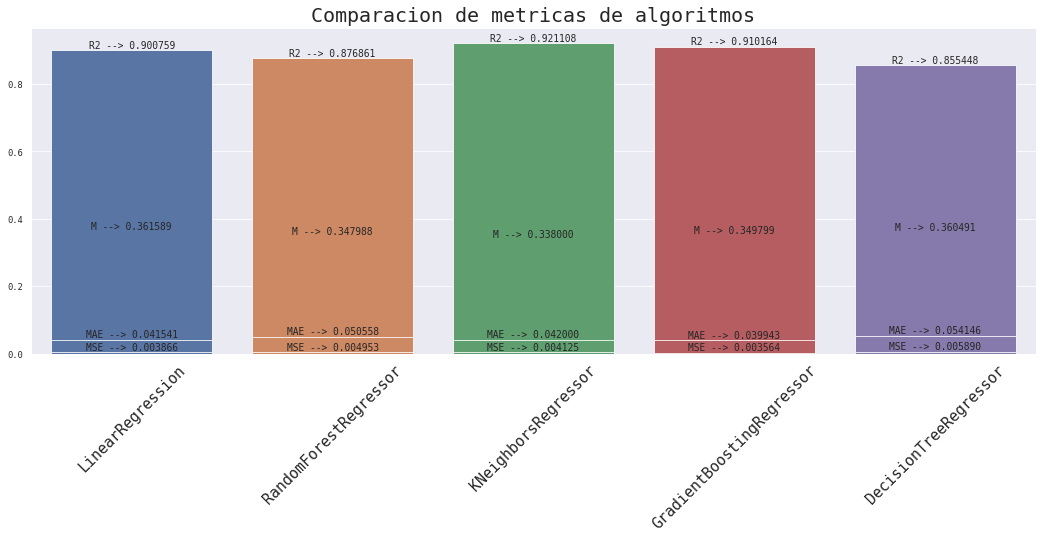

In [64]:
sns.set(context="paper", font="monospace")

fig, ax = plt.subplots(figsize=(18, 6))

metrics=['M','R2','MAE','MSE','RMSE','RSS']

for i in range(np.max(df.Nombre_modelo.index)):
    # add the plot
    sns.barplot(x='Nombre_modelo', y=f'{metrics[i]}', data=df, capsize=0.2, ax=ax)
    # add the annotation
    ax.bar_label(ax.containers[-1], fmt=f'{metrics[i]} --> %.6f', label_type='edge')
    ax.set(ylabel='')

plt.xticks(rotation=45,fontsize=15)
plt.xlabel('')
plt.title('Comparacion de metricas de algoritmos',fontsize=20)
plt.show()
